# Churn Risk Rate Ranking (Classification)
#### by Pilosyan Karen

Let's start by understanding the describtion of the task that will be reffered to in this project. There is a certain company website which has 36992 users, and the company wants to rank its users to 6 categories based on the riskiness of them leaving the company. We assign integer values for each risk level for each user: 0 - being the lowest risk, 5 - being the highest risk. So, if the user is very likely to stop using the company/website product and leave to another provider, we will assign that user higher score (i.e. 5). This score is reffered to as <i> churn_risk_score</i>. This task was offered by <i>kaggle</i>. Please see the link for more information: https://www.kaggle.com/imsparsh/churn-risk-rate-hackerearth-ml?select=train.csv. The name of the company or website is not provided. We are only provided with the dataset (train.csv) containing 36992 observations and 25 features. There is also a <i> test.csv</i> dataset provided, containing 19919 observations and 24 features (<i>churn_risk_score</i> excluded), but I will only work with the train dataset, because without the depended variable provided, I cannot check the goodness of my model anyways, and I will only fill in <i>churn_risk_score</i>, which is not interesting.

So the goal of this project is to create such a model that, based on some features (i.e. 'points in wallet', 'feedback'), will assign proper <i>churn_risk_scores</i> for each user. In order to do this, I will try different classification models, based on the train dataset, evaluate and interpret the results for each model, and finally, find out which one is the best model to choose. 

Also, note that people who provided this data, had no way of knowing the real churn score. They predicted it, the same way I will attempt to do. But the goal of this task is to learn.

Let's start with importing all the necessary modules.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv('train.csv') 

In [3]:
pd.set_option('display.max_columns', df.shape[0]+1)  # to see all the features 
df.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,16,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,14,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,11,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,20,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5


In [4]:
df.shape

(36992, 25)

In [5]:
df.isna().sum()  # amount of null values for each feature

customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                 5428
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            288
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3443
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

## Dropping unnecessary columns

Let's drop some of the unnecessary columns which logically, are not connected with churn score.

In [6]:
df = df.drop(['customer_id', 'Name', 'security_no', 'referral_id'], axis=1)

In [7]:
a = df[df['past_complaint']=='No']
a['complaint_status'].value_counts()

Not Applicable    18602
Name: complaint_status, dtype: int64

The column <i>past_complaint</i> contains 'Yes' and 'No' answers. If the value is 'Yes', the column <i>complaint_status</i> describes to what extend the complaint was dealt with. If the value is 'No', the column <i>complaint_status</i> contains the value 'Not Applicable' for that observation. So only from <i>complaint_status</i> we can understand if there was a 'past_complaint' or not. So, we can drop 'past_complaint'.

In [8]:
df = df.drop('past_complaint', axis=1)

Let's look at all the features, what values they contain and frequencies for each value.

In [9]:
for i in df.columns:
    print(i)
    print(df[i].value_counts())
    print("--------------------------")

age
33    720
16    716
42    716
38    714
30    711
61    709
57    704
60    704
41    699
59    696
55    695
28    694
34    692
47    691
21    689
32    685
17    683
56    682
29    681
45    680
48    680
46    679
58    678
22    677
62    677
53    675
26    675
52    672
64    672
14    670
10    670
49    669
23    669
36    668
44    661
12    661
19    660
51    660
27    659
43    657
35    656
63    656
50    656
11    654
13    654
37    653
15    649
24    645
39    642
20    641
31    636
25    635
18    629
40    628
54    608
Name: age, dtype: int64
--------------------------
gender
F          18490
M          18443
Unknown       59
Name: gender, dtype: int64
--------------------------
region_category
Town       14128
City       12737
Village     4699
Name: region_category, dtype: int64
--------------------------
membership_category
Basic Membership       7724
No Membership          7692
Gold Membership        6795
Silver Membership      5988
Premium Membership   

## Churn Risk Score

The column 'churn_risk_score' contains the value '-1', 1163 times, which I understand as NaN. So, one thing I can do, is to fill in these values according to the frequencies of the others or fill in with the overall mean value (3). But I believe we can afford losing those 1163 values, and keep the accurate scores insead of having guessed values. So let me drop those. 

In [10]:
df = df.drop(df[df['churn_risk_score'] == -1].index)  # finding indeces of those rows for which churn is -1.
                                                      # Drop those indeces

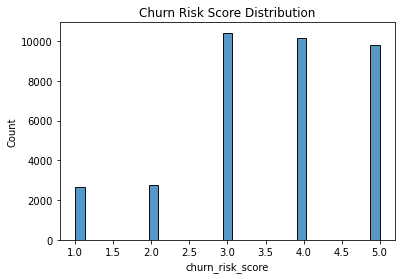

In [11]:
ax = sns.histplot(data=df, x="churn_risk_score")
ax.set_title('Churn Risk Score Distribution');

Well, this already is not looking good, because we see the data is imbalanced towards values 3, 4, 5. The imbalanced data causes the model to give less attention to it, so during test data, the values 1 and 2 will easily be confused with other values, because model didn't train well on these 2 cases. So we need to note that in this case evaluating a model with simpler metrics like <i>accuracy score</i> can be misleading. The classifier will predict the most common classes without performing any analysis of the features and it will have a high accuracy rate, obviously not the correct one.  

There are techniques to deal with imbalanced data, such as <i>Resampling Technique</i> or <i>Synthetic Minority Oversampling Technique (SMOTE)</i>. The idea of the first one, for example, is either to remove random samples from the more frequent classes, or adding more observations to the less frequent classes. SMOTE works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors. However these techniques, of course, have their disadvantages of creating false observations that can hurt the model. So since in our case, the imbalance is not thaat much (in my opinion), I will proceed by leaving it however it is.

## Dealing with Not Available Values

In the dataset there are a lot of NA values that are not <i>null</i>, but are represented like 'Unknown', '?', '-999', etc. Let's turn them into numpy <i>NaN</i> values, to deal with them as such later on.

In [12]:
df = df.replace('Unknown', np.nan)
df = df.replace('?', np.nan)
df = df.replace('Error', np.nan)
df = df.replace(-999, np.nan)
df = df.replace('No Information Available', np.nan)

# avg_time_spent has negative values, which makes no sense, so let's make them NaN as well

df['avg_time_spent'] = df['avg_time_spent'].replace(df['avg_time_spent'][df['avg_time_spent'] <= 0].values, np.nan)

I want to turn the feature 'joining_date' into a numerical value. The earlier that date observation (closer to today), the smaller its numerical value will be. By the way, when we turn categorical features into random numbers, most models think that one label is <i>bigger</i> than the other: for example if we assign <i>cat = 1, dog = 2</i>, the computer thinks dog > cat. But in case of ordinal labeling, the order makes sense: for example, <i>bad = 0, good = 1, very good = 2</i>. So ordinal labeling for time data makes sense to me.   

In [13]:
df['joining_date'] = df['joining_date'].astype('datetime64[ns]')  # turning from object type to date type
df['joining_date'] = pd.to_numeric(df['joining_date'])            # turning from date type to numeric type

Now I want to differentiate numeric types from object types. I will turn numeric types to 'float64'.

In [14]:
# If feature types can be changed to float, turn. If not, pass

for i in df.columns:
    try:
        df[i] = df[i].astype('float64')
    except:
        pass

For the object type features, I can't fill in the NaN values with mean values, so I will fill them in according to the frequencies of the other values. For example, in the 'feedback' column, if the value 'Poor Product Quality' comes across more often than the value 'Products always in Stock', 'Poor Product Quality' will have more impact on NaN values than 'Products always in Stock'.

In [15]:
for i in df.columns:
    if df[i].isna().sum() > 0 and df[i].dtype != 'float64': # if feature is not numeric and has NaN values 
        s = df[i].value_counts(normalize=True) # fill based on frequencies of others
        df.loc[df[i].isna(), i] = np.random.choice(s.index, p=s.values, size=df[i].isna().sum())

For the numeric features, simply fill in with mean values.

In [16]:
for i in df.columns:
    if df[i].isna().sum() > 0 and df[i].dtype == 'float64':
        df[i] = df[i].fillna(df[i].mean())

In [17]:
# check for NA values. Should be no output

for i in range(len(df.isna().sum())):
    if df.isna().sum()[i] > 0:
        print('NA values')

## Encoding

#### Ordinal Encoding

In [18]:
ordinal_features = ['region_category', 'membership_category', 'preferred_offer_types', 'complaint_status', 
                    'feedback']

In [19]:
# logically assigning chronological orders to the labels

reg_labels = {"Town":1, "City":2, "Village":0}

fdbk = {"Poor Product Quality":0, "Too many ads":0, "Poor Website":0, "Poor Customer Service":0,
           "No reason specified":1, "Reasonable Price":2, "User Friendly Website":2, "Products always in Stock":2,
           "Quality Customer Care":2}

memberships = {"No Membership":0, "Basic Membership":1, "Premium Membership":5, "Silver Membership":2,
           "Gold Membership":3, "Platinum Membership":4}

complaints = {"Unsolved":0, "Solved in Follow-up":1, "Solved":1, "Not Applicable":2}

types = [reg_labels, fdbk, memberships, complaints]

In [20]:
# if the unique feature values are the same as one of the types above, map the feature values accordingly

for i in ordinal_features:
    for j in types:
        if set(j.keys()) == set(df[i].unique()):
            df[i] = df[i].map(j)    

#### Label Encoding

In [21]:
# label encoding for the rest of the features 

for i in df.columns:
    if df[i].dtype == "O":
            df[i] = df[i].astype('category')  # cat.codes work with type 'category' only
            df[i] = df[i].cat.codes

In [22]:
df.head()

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,complaint_status,feedback,churn_risk_score
0,18.0,0,0,4,1.502928e+18,0,1,2,2,19686,17.0,300.63,53005.25,17.0,781.750000,1,1,2,2,2.0
1,32.0,0,2,5,1.503878e+18,1,1,1,1,15407,16.0,306.34,12838.38,10.0,686.849231,1,0,1,2,1.0
2,44.0,0,1,0,1.478822e+18,1,1,1,2,27964,14.0,516.16,21027.00,22.0,500.690000,0,1,1,0,5.0
3,37.0,1,2,0,1.477699e+18,1,1,1,1,19480,11.0,53.27,25239.56,6.0,567.660000,0,1,0,0,5.0
4,31.0,0,2,0,1.505174e+18,0,0,2,1,19267,20.0,113.13,24483.66,16.0,663.060000,0,1,1,0,5.0


## Correlation Matrix (HeatMap)

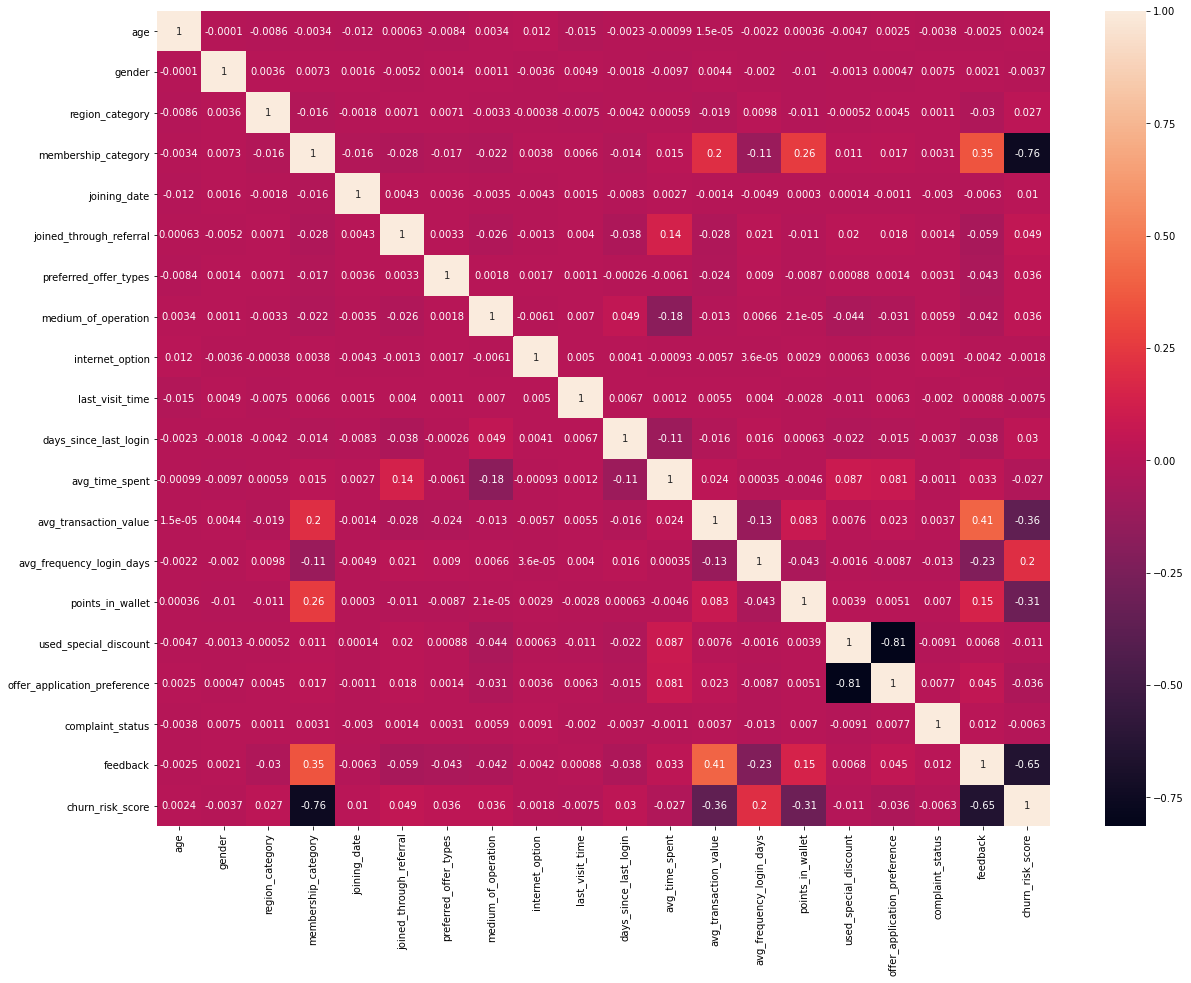

In [23]:
corrMatrix = df.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corrMatrix, annot=True)
plt.show()

As we see, there is a potential multicollinearity issue between features "used_special_discount" and "offer_application_preference": -0.81. So one of them needs to be eliminated. But both have very small correlations with "churn_risk_score", so I will end up not using any of them anyways. 

## Feature Selection

From the correlation matrix heatmap above, we can already see which features are more correlated with our dependent variable. But in order to recheck, let's use the class SelectKBest from library sklearn.

In [24]:
y = df.loc[:,'churn_risk_score']  # dependent variable
X = df.loc[:,'age':'feedback']    # (initial) independent variables

In [25]:
kBest = SelectKBest(f_regression, k=5) 
kBest.fit(X, y) 
bestFeatures = kBest.get_support(indices=True)
X = X.iloc[:, list(bestFeatures)]
X

,membership_category,avg_transaction_value,avg_frequency_login_days,points_in_wallet,feedback
0,4,53005.25,17.00000,781.750000,2
1,5,12838.38,10.00000,686.849231,2
2,0,21027.00,22.00000,500.690000,0
3,0,25239.56,6.00000,567.660000,0
4,0,24483.66,16.00000,663.060000,0
...,...,...,...,...,...
36987,1,27277.68,6.00000,639.510000,1
36988,1,11069.71,28.00000,527.990000,0
36989,1,38127.56,15.96304,680.470000,0
36990,4,2378.86,20.00000,197.264414,1


As expected, the 5 features chosen with this technique match with the 5 features that had the highest correlations with <i>churn_risk_score</i>.

Later on, some models will require the dataframe X to be standardized (i.e. Logistic Regression), so let's do that now, before getting into model fitting.

In [26]:
scaler = preprocessing.StandardScaler().fit(X)

X_transformed = scaler.transform(X)

X = pd.DataFrame(X_transformed, columns=X.columns[0:len(X.columns)])

In [27]:
X.head()

,membership_category,avg_transaction_value,avg_frequency_login_days,points_in_wallet,feedback
0,1.112862,1.216415,0.118435,5.122080e-01,2.062039
1,1.715524,-0.845085,-0.681060,3.068010e-15,2.062039
2,-1.297787,-0.424818,0.689502,-1.004757e+00,-0.634340
3,-1.297787,-0.208615,-1.137914,-6.433002e-01,-0.634340
4,-1.297787,-0.247410,0.004221,-1.283976e-01,-0.634340


## Splitting into Train and Test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
X_test.shape

(10749, 5)

In [30]:
X_train

,membership_category,avg_transaction_value,avg_frequency_login_days,points_in_wallet,feedback
21211,-1.297787,-1.069419,-7.952732e-01,3.068010e-15,-0.634340
33562,-0.092462,-1.178077,1.146356e+00,3.336113e-01,-0.634340
35261,1.715524,0.862006,-1.023700e+00,8.576726e-02,-0.634340
19817,-0.695125,0.846059,-7.952732e-01,1.423322e+00,-0.634340
5214,-1.297787,0.381906,-1.623071e-15,-5.394021e-01,-0.634340
...,...,...,...,...,...
16850,-0.695125,0.197422,-1.623071e-15,1.392250e+00,-0.634340
6265,1.112862,-1.226292,-1.623071e-15,2.674944e-01,-0.634340
11284,-0.092462,-0.369053,2.326483e-01,8.333848e-02,-0.634340
860,-0.092462,0.896562,-1.252127e+00,-1.115581e-01,-0.634340


## Some Theory

Before getting into constructing models and interpreting the results, let's first understand some concepts, with the help of which we can interpret the results of our models.

#### <i>Confusion Matrix</i>  
<br>
<b>True Positive (TP)</b> = model <i>correctly</i> predicts the <i>positive</i> class. Example: model predicted class '4' exactly (so, NOT something else), and the ACTUAL value WAS '4' (so, NOT something else). <br>
<b>True Negative (TN)</b> = model <i>correctly</i> predicts the <i>negative</i> class. Example: model predicted NOT class '4' (so, something else) and the actual value was INDEED NOT '4' (so, something else). <br>
<b>False Positive (FP)</b> = model <i>incorrectly</i> predicts the <i>positive</i> class. Example: model predicted NOT class '4' (so, something else), but the ACTUAL value WAS '4' (so, NOT something else). <br>
<b>False Negative (FN)</b> = model <i>incorrectly</i> predicts the <i>negative</i> class. Example: model predicted class '4' (so, NOT something else), but the actual value was NOT class '4' (so, something else). <br>

<img src="multiclass_confusion_matrix.png" style="width: 500px;"/> 

1) The total number of any class (in test examples) -> the sum of the corresponding row (i.e. TP + FN for that class) <br>
2) The total number of <b>FN's</b> for a class -> sum of values in the corresponding <b>row</b> (excluding TP) <br>
3) The total number of <b>FP's</b> for a class -> sum of values in the corresponding <b>column</b> (excluding TP) <br>
4) The total number of <b>TN's</b> for a class -> sum of all the columns and rows <b>excluding that class's column and row</b> <br>


<b>Precision</b> = TruePositives $\div$ (TruePositives + FalsePositives) -> when it predicts positive, how often is it correct? <br>
<b>Recall</b> = TruePositives $\div$ (TruePositives + FalseNegatives) -> out of all ACTUAL POSITIVE cases, how often it predicted positive? <br>
<b>Accuracy</b> = (TruePositives + TrueNegatives) $\div$ total -> overall, how often it predicted correctly? <br>
<b>Balanced Accuracy</b> = (Sum of all Precisions) $\div$ (number of classes) <br>
<b>F-Measure</b> = (2 * Precision * Recall) $\div$ (Precision + Recall) -> takes into account both Precision and Recall. Highest value is 1, when both are perfect, and 0 when either Precision or Recall is 0. <br>
<b>Support</b> = Number of observations for that class (in test dataset)

## Logistic Regression

In [31]:
class_weights = {1.0: 100, 2.0: 100, 3.0: 3, 4.0: 2.5, 5.0: 2.5}

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty="l2", C=1,
                           class_weight=None, max_iter=1000)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)
bal_score = metrics.balanced_accuracy_score(y_pred, y_test)
score = metrics.accuracy_score(y_pred, y_test)

print("Accuracy = " + str(score))
print("Balanced Accuracy = " + str(bal_score))
print("\n" + "Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred)) + "\n")
print(classification_report(y_test, y_pred))

Accuracy = 0.639315285142804
Balanced Accuracy = 0.6333095085960789

Confusion Matrix: 
[[ 519  289    0    0    0]
 [ 341  477    0    0    0]
 [   0    0 2485  743    3]
 [   0    0  713 1491  821]
 [   0    0    0  967 1900]]

              precision    recall  f1-score   support

         1.0       0.60      0.64      0.62       808
         2.0       0.62      0.58      0.60       818
         3.0       0.78      0.77      0.77      3231
         4.0       0.47      0.49      0.48      3025
         5.0       0.70      0.66      0.68      2867

    accuracy                           0.64     10749
   macro avg       0.63      0.63      0.63     10749
weighted avg       0.64      0.64      0.64     10749



Before interpreting the results, I would like to obtain these results myself by using the above formulas. Just to understand how things work and check.

In [32]:
print("Precision for class 3: 2485/(2485 + 713) = " + str(2485/(2485+713)))
print("Recall for class 3: 2485/(2485 + 743 + 3) = " + str(2485/(2485+743+3)))
print("f1 score for class 3: (2 * 0.78 * 0.77)/(0.77 + 0.78) = " + str((2 * 0.78 * 0.77)/(0.77 + 0.78)))
print("Accuracy: (diagonal values) ->(519+477+2485+1491+1900)/total(10749) = " + str((519+477+2485+1491+1900)/10749))
print("Balanced Accuracy: (0.60 + 0.62 + 0.78 + 0.47 + 0.70)/5 = " + str((0.60 + 0.62 + 0.78 + 0.47 + 0.70)/5))
print("Macro Avg: for f1: (0.62+0.60+0.77+0.48+0.68)/5 = " + str((0.62+0.60+0.77+0.48+0.68)/5))
print("Weighted Avg for f1: (0.62*808+0.6*818+0.77*3231+0.48*3025+0.68*2867)/10749 = " + \
      str((0.62*808+0.6*818+0.77*3231+0.48*3025+0.68*2867)/10749))

Precision for class 3: 2485/(2485 + 713) = 0.7770481550969356
Recall for class 3: 2485/(2485 + 743 + 3) = 0.7691117301145156
f1 score for class 3: (2 * 0.78 * 0.77)/(0.77 + 0.78) = 0.7749677419354839
Accuracy: (diagonal values) ->(519+477+2485+1491+1900)/total(10749) = 0.639315285142804
Balanced Accuracy: (0.60 + 0.62 + 0.78 + 0.47 + 0.70)/5 = 0.634
Macro Avg: for f1: (0.62+0.60+0.77+0.48+0.68)/5 = 0.63
Weighted Avg for f1: (0.62*808+0.6*818+0.77*3231+0.48*3025+0.68*2867)/10749 = 0.6401702483951996


The results are not that bright. In a lot of cases, we see that the model confuses class 1 and 2 separetly, and 3,4, 5 separetly. It is easy to confuse within 1 unit (i.e. classify 1 as 2), although classes 2 and 3 are never confused amongst themselves. Best precision and recall is for class 3, probably because it's the more frequent class. Tweaking the parameters don't really increase the results, it's pretty much the same. You see I intentionally added parameters, but the results don't change that much. 

Logistic Regression isn't the best model for this specific task. The classes are easily confused. Logistic Regression tries to separate each class with a line, but doesn't care about the margins between 2 classes, like SVM does. We will see below that SVM does silimar technique but obtains better results for this reason.

## SVM

In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = SVC(C=10, kernel='rbf', gamma='auto', max_iter=-1)
clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
bal_score = metrics.balanced_accuracy_score(y_pred, y_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Balanced Accuracy = " + str(bal_score))
print("\n" + "Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred)) + "\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.7615592148106801
Balanced Accuracy = 0.7653159223159619

Confusion Matrix: 
[[ 627  181    0    0    0]
 [ 230  588    0    0    0]
 [   0    0 2873  358    0]
 [   0    0  264 1281 1480]
 [   0    0    3   47 2817]]

              precision    recall  f1-score   support

         1.0       0.73      0.78      0.75       808
         2.0       0.76      0.72      0.74       818
         3.0       0.91      0.89      0.90      3231
         4.0       0.76      0.42      0.54      3025
         5.0       0.66      0.98      0.79      2867

    accuracy                           0.76     10749
   macro avg       0.77      0.76      0.75     10749
weighted avg       0.78      0.76      0.75     10749



As you see, SVM is more suitable for more complex classification tasks like this. The results are much better. Although it's much slower than Logistic Regression, but in our case the observations are not that many, so it's better to use SVM. But we see that for the class 4 it fails to predict well. It thought 278 cases were class 3, and 1490 cases were class 5, but those cases were actually 4. Similar problem was with Logistic Regression, but the recall for class 4 was 0.49. We can conclude so far that the reason for such low accuracies is that the number of observations is too little and the data is noisy. And again, tweaking the arguments doesn't really improve the results. <br> 
By the way, the imbalance of the data seems not to be that much of a problem. Main confusion is between classes 3 and 4.

## Decision Tree

In [34]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=7) 

clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
bal_score = metrics.balanced_accuracy_score(y_pred, y_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Balanced Accuracy = " + str(bal_score))
print("\n" + "Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred)) + "\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.794957670480975
Balanced Accuracy = 0.811519701924267

Confusion Matrix: 
[[ 778   30    0    0    0]
 [ 323  495    0    0    0]
 [   0    0 3097  134    0]
 [   0    0  377 1519 1129]
 [   0    0    0  211 2656]]

              precision    recall  f1-score   support

         1.0       0.71      0.96      0.82       808
         2.0       0.94      0.61      0.74       818
         3.0       0.89      0.96      0.92      3231
         4.0       0.81      0.50      0.62      3025
         5.0       0.70      0.93      0.80      2867

    accuracy                           0.79     10749
   macro avg       0.81      0.79      0.78     10749
weighted avg       0.81      0.79      0.78     10749



The results are better with Decision Tree. The algorithm is a lot different, but the same thing happens here: class 4 is badly predicted. Maximum depth is the optimum at number 7, as I discovered after trying around different numbers.

## Random Forest

In [35]:
clf = RandomForestClassifier(max_depth=8, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

bal_score = metrics.balanced_accuracy_score(y_pred, y_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Balanced Accuracy = " + str(bal_score))
print("\n" + "Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred)) + "\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.793283096101963
Balanced Accuracy = 0.8042605969910307

Confusion Matrix: 
[[ 725   83    0    0    0]
 [ 283  535    0    0    0]
 [   0    0 3016  215    0]
 [   0    0  316 1438 1271]
 [   0    0    0   54 2813]]

              precision    recall  f1-score   support

         1.0       0.72      0.90      0.80       808
         2.0       0.87      0.65      0.75       818
         3.0       0.91      0.93      0.92      3231
         4.0       0.84      0.48      0.61      3025
         5.0       0.69      0.98      0.81      2867

    accuracy                           0.79     10749
   macro avg       0.80      0.79      0.78     10749
weighted avg       0.81      0.79      0.78     10749



Random Forest, although is a more sophisticated algorithm compared to Decision Tree, but it doesn't mean it will always provide better results than Decision Tree. It's close, but still Decision Tree is on the lead.

## KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=6)
clf.fit(X, y)

y_pred = clf.predict(X_test)
bal_score = metrics.balanced_accuracy_score(y_pred, y_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Balanced Accuracy = " + str(bal_score))
print("\n" + "Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred)) + "\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.824262722113685
Balanced Accuracy = 0.8192042076481686

Confusion Matrix: 
[[ 714   94    0    0    0]
 [ 231  585    1    1    0]
 [   0    0 3065  165    1]
 [   0    0  288 2282  455]
 [   0    0    1  652 2214]]

              precision    recall  f1-score   support

         1.0       0.76      0.88      0.81       808
         2.0       0.86      0.72      0.78       818
         3.0       0.91      0.95      0.93      3231
         4.0       0.74      0.75      0.75      3025
         5.0       0.83      0.77      0.80      2867

    accuracy                           0.82     10749
   macro avg       0.82      0.81      0.81     10749
weighted avg       0.83      0.82      0.82     10749



When k=1, the accuracy results will be 100%. This is because the closest point to any training data point is itself. Hence the prediction is always accurate with K=1. I chose the number 6, because we have 5 classes, and if the new observation is looking at 5 neighbors, it won't know which one to choose. But in case k=6, there will be at least 2 of the same class neighbors, and this new observation will be classified with them. But there is a risk that the model is overfitting. So I belive Decision Tree is the best so far, because it's more reliable.

## Neural Network

In [37]:
import tensorflow as tf
from tensorflow import keras

y_train = tf.keras.utils.to_categorical(y_train, num_classes = 6) # num_classes is (greatest number in y_train) + 1

In [38]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense

# Initialize the constructor
model = Sequential()

# Add layers
model.add(Dense(15, activation='relu', input_dim=5))
model.add(Dense(8, activation='relu', input_dim=15))
model.add(Dense(6, activation='relu', input_dim=8))

# Add output layer 
model.add(Dense(6, activation='softmax'))

In [39]:
# Model output shape
model.output_shape

# Model summary
model.summary()

# Model config
#model.get_config()

# List all weight tensors 
#model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 128       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 42        
Total params: 314
Trainable params: 314
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
                   
history = model.fit(X_train, y_train,epochs=8, batch_size=1, verbose=1)

Epoch 1/8
25080/25080 [==============================] - 24s 926us/step - loss: 0.4315 - accuracy: 0.7520
Epoch 2/8
25080/25080 [==============================] - 29s 1ms/step - loss: 0.4240 - accuracy: 0.7509
Epoch 3/8
25080/25080 [==============================] - 28s 1ms/step - loss: 0.4178 - accuracy: 0.7556
Epoch 4/8
25080/25080 [==============================] - 28s 1ms/step - loss: 0.4177 - accuracy: 0.7594
Epoch 5/8
25080/25080 [==============================] - 28s 1ms/step - loss: 0.4131 - accuracy: 0.7589
Epoch 6/8
25080/25080 [==============================] - 28s 1ms/step - loss: 0.4118 - accuracy: 0.7608
Epoch 7/8
25080/25080 [==============================] - 29s 1ms/step - loss: 0.4044 - accuracy: 0.7610
Epoch 8/8
25080/25080 [==============================] - 28s 1ms/step - loss: 0.4106 - accuracy: 0.7596


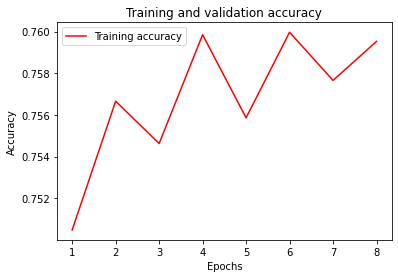

In [43]:
history_dict = history.history

# learning curve
# accuracy
acc = history_dict['accuracy']

# loss
loss = history_dict['loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [44]:
y_pred = model.predict(X_test).argmax(axis=1)

bal_score = metrics.balanced_accuracy_score(y_pred, y_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Balanced Accuracy = " + str(bal_score))
print("\n" + "Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred)) + "\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.7658386826681551
Balanced Accuracy = 0.7620592350413496

Confusion Matrix: 
[[ 603  205    0    0    0]
 [ 194  624    0    0    0]
 [   3    0 2972  256    0]
 [   0    0  320 2109  596]
 [   0    0    0  943 1924]]

              precision    recall  f1-score   support

         1.0       0.75      0.75      0.75       808
         2.0       0.75      0.76      0.76       818
         3.0       0.90      0.92      0.91      3231
         4.0       0.64      0.70      0.67      3025
         5.0       0.76      0.67      0.71      2867

    accuracy                           0.77     10749
   macro avg       0.76      0.76      0.76     10749
weighted avg       0.77      0.77      0.77     10749



I played around the number of layers and units to get the highest accuracy scores, but not much changes for different numbers. The results are almost the same as you see above. I thought that Neural Network would be the best model, but it's questionable. One thing that is good, is that results for class 4 are better than we had in Decision Tree. The best results were produced by KNN, but I'm afraid to come to that conclusion because it can be overfitting while others don't. As a future work it would be nice to do cross validation to make sure. 

Thank you for this nice opportunity to strenghten my knowledge through practice. This has been very helpful, I have learned a lot. I know there is so much more I could have learned and done in this project. As a future work, I need to dive more deeply into how all these algorithms work, what are their strenghts and weaknesses for different tasks. 